## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Summary](#Summary)
- [References](#References)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. For better accuracy, these rows will be removed and store the new dataframe in **df2**.

In [8]:
index_names = df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').index
df2 = df.drop(index_names)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
#Double Check the number of row in the new dataframe
df2.shape[0]

290585

`3.` Checking for duplicate rows and evaluating them

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
duplicate_user = df2[df2.duplicated(['user_id'])]
duplicate_user['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Since there is consistency with this id, we can probably just choose either and remove. We shouldn't be counting the same user more than once.

d. Removing **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [15]:
#Double Check that the duplicate row was removed
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


In [16]:
#Number of rows after removing the duplicate user
df2.shape[0]

290584

`4.` Checking the different probabilities in the df2.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

**Based on computing the probablities above, the conversion rate of the control group is higher than that of the treatment group by 0.0016. However, that is no suffcient evidence to rely on in determining whether the new treatment page leads to more conversions. The siginficance of this 0.0016 difference still remains unknown.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, the decision will be made just based on all the data provided. If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses will be stated in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: \mu_{new} - \mu_{old} <= 0$$


$$H_1: \mu_{new} - \mu_{old} > 0$$

`2.` Assuming that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

The sample size for each page will be equal to the ones in **ab_data.csv**.  <br><br>

The sampling distribution will be performed for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice(2, size=n_new, p=[(1-p_new) ,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice(2, size=n_old, p=[(1-p_old) ,p_old])
old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.0026449973345842454

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above and storing all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    control_mean = np.random.choice(2, size=n_old, p=[(1-p_old) ,p_old]).mean()
    experiment_mean = np.random.choice(2, size=n_new, p=[(1-p_new) ,p_new]).mean()
    p_diffs.append(experiment_mean - control_mean)

i. Ploting a histogram of the **p_diffs**.  

In [29]:
# convert to numpy array
p_diffs = np.array(p_diffs)

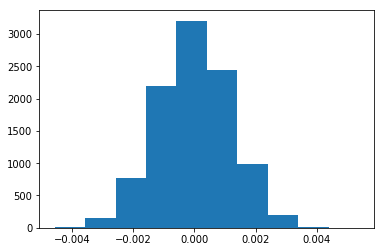

In [30]:
# plot sampling distribution
plt.hist(p_diffs);

The above plot looks like what was expected based on the Central Limit Theorem, namely a normal distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# get the average conversion rate for control group
control_mean = df2.query('group == "control"').converted.mean()

# get the average conversion rate for treatment group
treatment_mean = df2.query('group == "treatment"').converted.mean()

# compute observed conversion difference 
obs_diff = treatment_mean - control_mean

# display observed difference
obs_diff

-0.0015782389853555567

In [32]:
(p_diffs > obs_diff).mean()

0.90410000000000001

**By comparing the above p-value (approximately 0.9) to the Type I error threshold of 5%, we fail to reject the null hypothesis since the p-value is larger than 0.05. This shows that the conversion rate of the old page is greater than or equal to that of the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. First we will calculate below the number of conversions for each page, as well as the number of individuals who received each page. We will also use the previously calculated `n_old` and `n_new` refer to the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
convert_old, convert_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value. This is the [link](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) used for this built-in function.

In [34]:
z_score,p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative = 'larger')
print('p-value:' , p_value)
print('z_score:' , z_score)

p-value: 0.905058312759
z_score: -1.31092419842


In [35]:
#find the significance of our z-score
from scipy.stats import norm
norm.cdf(z_score)

0.094941687240975514

**Based on this [link](https://www.statisticshowto.com/probability-and-statistics/find-critical-values/), the critical value of 95% confidence level is 1.96. And since the z-score is smaller than the critical value, we fail to reject the Null hypothesis of this test.** 

**Furthermore, the p-value of (approximately 0.91) is larger than the Type I error threshold of 0.05, failing to reject the Null hypothesis as well.**

**The results agree with the previous findings, that the conversion rate of the old page is greater than or equal to that of the new page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression** will be used as the response variable is of a categorical data type.

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
#Create a column for the intercept
df2['intercept'] = 1

In [37]:
#Create a dummy variable column for each group
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

In [38]:
#Looking at the top few rows
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Using **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model to predict whether or not an individual converts. 

In [39]:
#Importing library and adding missing function
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

#instantiate and fit the model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 30 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        08:19:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with **ab_page** is different from the p-value computed in part II due to the difference in the types of the tests performed. In the regression model, a two-tailed test is performed. On the contrary, the above A/B testing in part II is a one-sided test. 

Below are the null and alternative hypotheses associated with this regression model:

$$H_0: \beta{1} = 0$$


$$H_1: \beta{1} \neq 0$$

where β is the expected change in the conversion rate for an additional user using either of the landing pages or the slope.

**The p-value associated with ab_page is 0.190 which is larger than the Type I Error threshold of 0.05, hence we fail to reject the null hypothesis. Therefore, there is no statistically siginificant evidence that the conversion rate of the new page differs from that of the old page.**

f. Now, considering that other things might influence whether or not an individual converts. It is a good idea to consider other factors to add into your regression model for **achieving the best prediction model in addition to identifying variables that would be really useful in identifing user conversion. However, this could bring problems such as Multicollinearity, Outliers/ High leverage points, Non-linearity of the response-predictor relationships, Correlation of error terms...etc**

g. Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in. We will add another dataset **countries.csv** and merge it with the existing one

In [41]:
#read the countries dataset
df3 = pd.read_csv('countries.csv')

#Looking at the top few rows
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
#Inner joining both dataframes

df4 = df2.set_index('user_id').join(df3.set_index('user_id'), how='inner')

#Looking at the top few rows
df4.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


Will the that country have an impact on conversion? Before answering that, let's first create dummy variables for the country column.

In [43]:
#checking unique values in country column
df4.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [44]:
#Create a dummy variable column for each group
df4[['CA', 'UK', 'US']] = pd.get_dummies(df4['country'])
df4.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [45]:
#Create a column for the intercept
df4['intercept'] = 1

#instantiate and fit the model
logit_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page','CA', 'UK']])
results = logit_mod.fit()

#view the summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        08:40:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Based on the results, Country (on its own) does not have a statistically siginficant impact on conversion. The p-values of CA and UK are 0.130, 0.457 respectively which is larger than the Type I Error threshold of 0.05, hence we fail to reject the null hypothesis. As a result, there is no statistically siginificant evidence that the conversion rate differs across the countries provided in the dataset.

h. Though we have now looked at the individual factors of country and page on conversion, we would like to look at an interaction between page and country to see if there significant effects on conversion. We will start by creating the necessary additional columns, and then fit the new model.  

In [46]:
#create page and country interaction columns
df4['page_CA'] = df4['ab_page']*df4['CA']
df4['page_UK'] = df4['ab_page']*df4['UK']
df4.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,page_CA,page_UK
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [47]:
#instantiate and fit the model
logit_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page','CA', 'UK', 'page_CA','page_UK']])
results = logit_mod.fit()

#view the summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 30 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        08:41:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Again, we see no significant effect on conversion even after adding the interaction between page and country. The p-values of page_CA and page_UK are 0.383, 0.238 respectively which is larger than the Type I Error threshold of 0.05, hence we fail to reject the null hypothesis. 

As a result, there is no statistically siginificant evidence that the interaction between page and country can predict user conversion. Moreover, this suggests that the interaction term isn't necessary in our model.

##### Additional Information: Experiment Duration

In [48]:
min(df4.timestamp), max(df4.timestamp)

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

### Summary

The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 

Participants were from Canada, UK and US and had almost equal probabilities of receiving either of the pages. The experiment lasted around 22 days and multiple approaches namely A/B testing and Regression were used to help the company understand if they should implement this new page.

With a type I error threshold of 5%, the conversion rate of the old page is greater than or equal to that of the new page. Accordingly, the new page so far is not promising to increase the conversion rate; either the company continues to run the experiment for a longer duration for a final decision in case the timeline allows or decides to keep the old page. 

From a cost perspective, the budget allocated for launching the new page could be allocated to another area given that the conversion rate did not increase with the new page. Unless extending the experiment duration drastically increased the conversion rate - one possible reason could be due to change aversion where users did not have enough time to adjust to the changes. In that case, the gain from the conversion increase could be evaluated relative to the cost by management.

##### Limitations: 

- Running a hypothesis test continuously as each observation was observed, is out of scope for this project. 
- Accounting for novelty effect and change aversion due to insufficent data of the participants of this experiment
- The only metric the company was using is conversion rate; there is a possibility that other important metrics are not identified
- The short duration of the experiment won't account for or changes in behavior based on seasonal events.
- The data did not include other demographic features of the participants as well. Plus, other information such as the different steps users go through until reaching the check out for purchasing the product and the avergage time spent in each step.


### References

- https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
- https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

- https://knowledge.udacity.com/questions/195459

- https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/

- https://github.com/statsmodels/statsmodels/issues/3931

- https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/

## Submitting Project

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0